In [111]:
import random
import spacy
import copy
import warnings
import pandas as pd
from tqdm import tqdm
from time import time
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import sem
from scipy.stats import ttest_ind as t_test

In [2]:
SAMPLE_SIZE = 0.01
SAMPLE_NUMBER = 10
EMOJIS =["⌨", "☑", "✑", "⚖", "🂱"]
random.seed(9281638162)

In [3]:
#spacy.require_gpu()
nlp = spacy.load("pt_core_news_lg")
nlp.max_length = 3000000 # Some few texts in the sample have more than 1e6 chars

In [4]:
type_df = pd.read_csv('carolina_balanced_typologies.csv')

In [ ]:
domains = type_df['domain'].unique()
samples = []
extracted_texts = {}
for domain in domains:
    condition = type_df['domain'] == domain
    extracted_domain = type_df.loc[condition, 'body'].to_list()
    random.shuffle(extracted_domain)
    extracted_texts[domain] = extracted_domain

for sample in range(SAMPLE_NUMBER):
    print(f"Obtaining Sample {sample}...")
    texts_per_domain = {}
    for domain in domains:
        partition_size = int(SAMPLE_SIZE * len(extracted_texts[domain]))
        print(f"\tProcessing domain {domain} ({partition_size} texts)...")
        t0 = time()
        
        partition = (sample * partition_size, (sample + 1) * partition_size)
        sampled_texts = extracted_texts[domain][partition[0]:partition[1]]
        texts_per_domain[domain] = [t for t in nlp.pipe(sampled_texts, n_process=20)]
        tf = time()
        dt = round((tf-t0)/60,1)
        print(f"\tDomain {domain} processed in {dt} min.")
        
    samples.append(texts_per_domain)
print("Text Sampling Completed.")

In [ ]:
sample_independent_features = {}
sample_dependent_features = []

print("Extracting sample-independent features...")
for domain in domains:
    print(f"domain {domain}")
    sample_independent_features[domain] = {"sent_len":[], "token_len":[], "punct_count":[], "stop_count":[]}
    for sample in range(SAMPLE_NUMBER):
        print(f"sample {sample}")
        for document in samples[sample][domain]:
            for sent in document.sents:
                punct_count = 0
                stop_count = 0
                if not (len(sent) == 1 and sent[0].pos_ in ["SPACE","PUNCT"]): #One space or one-punctuation sentences are not conidered
                    sample_independent_features[domain]['sent_len'].append(len(sent))
                    for token in sent:
                        if not token.is_stop:
                            if not token.is_punct:
                                if not token.pos_ == 'SPACE':
                                    sample_independent_features[domain]['token_len'].append(len(token))
                            else:
                                punct_count += 1
                        else:
                            stop_count += 1
                        sample_independent_features[domain]['punct_count'].append(punct_count)
                        sample_independent_features[domain]['stop_count'].append(stop_count)

print("Extracting sample-dependent features...")

for sample in range(SAMPLE_NUMBER):
    print(f"sample {sample}")
    sd_dict = {"pos":[], "lemma":[], "morph_gender":[], "morph_number":[], "morph_case":[], "morph_tense":[], "morph_mood":[], "morph_aspect":[], "dep":[], "ent_type":[]}
    sample_dependent_features.append({domain:copy.deepcopy(sd_dict) for domain in domains})
    for domain in domains:
        print(f"domain {domain}")
        for document in samples[sample][domain]:
            for sent in document.sents:
                for token in sent:
                    if not token.is_punct:
                        if not token.pos_ == 'SPACE':
                            sample_dependent_features[sample][domain]["pos"].append(token.pos_)
                            sample_dependent_features[sample][domain]["lemma"].append(token.lemma_)
                            if len(token.morph.get("Gender")) > 0:
                                sample_dependent_features[sample][domain]["morph_gender"].append(token.morph.get("Gender")[0])
                            if len(token.morph.get("Number")) > 0:
                                sample_dependent_features[sample][domain]["morph_number"].append(token.morph.get("Number")[0])
                            if len(token.morph.get("Case")) > 0:
                                sample_dependent_features[sample][domain]["morph_case"].append(token.morph.get("Case")[0])
                            if len(token.morph.get("Tense")) > 0:
                                sample_dependent_features[sample][domain]["morph_tense"].append(token.morph.get("Tense")[0])
                            if len(token.morph.get("Mood")) > 0:
                                sample_dependent_features[sample][domain]["morph_mood"].append(token.morph.get("Mood")[0])
                            if len(token.morph.get("Aspect")) > 0:
                                sample_dependent_features[sample][domain]["morph_aspect"].append(token.morph.get("Aspect")[0])
                            sample_dependent_features[sample][domain]["dep"].append(token.dep_)
                            sample_dependent_features[sample][domain]["ent_type"].append(token.ent_type_)

In [186]:

def plot_sample_independent(feature,xlim, ylim, xlabel, ignore=5*[""], figsize=(17,6), emojis=EMOJIS, style="darkgrid", context="talk", font_scale=0.7, palette="colorblind", alpha=0.5):
    sns.set(style=style)
    sns.set_context(context, font_scale=font_scale)
    fig, axs = plt.subplots(1, 5, figsize=figsize, sharey=True)
    plt.setp(axs, xlim=xlim,ylim=ylim, xlabel=xlabel)
    for i in range(5):
        data = sample_independent_features[domains[i]][feature] 
        if ignore[i] != None:
            data = [f for f in data if f != ignore[i]]
        mu = stat.mean(data)
        median = stat.median(data)
        sigma = sem(data)
        mode = stat.mode(data)
        textstr = '\n'.join((
        r'$\mu=%.3f$' % (mu, ),
        r'$\sigma=%.3f$' % (sigma, ),
        r'$\mathrm{Me}=%d$' % (median, ),
        r'$\mathrm{Mo}=%d$' % (mode, )))
        props = dict(boxstyle='round', facecolor=sns.color_palette(palette)[i], alpha=alpha)
        axs[i].text(0.5, 0.95, textstr, transform=axs[i].transAxes, fontsize=14, verticalalignment='top', bbox=props)
        sns.histplot(data=data, ax=axs[i], stat = "percent",discrete=True, element="step", color = sns.color_palette(palette)[i])
        axs[i].set_title(emojis[i] + " " + domains[i], fontsize=17)

    plt.savefig("plots/" + feature + ".pdf")
    plt.savefig("plots/" + feature + ".png")
    

In [8]:
def independent_compatibility_map(feature, title, equal_var=False, emojis=EMOJIS, context="poster", font_scale=1, annot=False):
    sns.set_context(context, font_scale=font_scale)
    
    p_values = {}
    for i in range(len(domains)):
        p_values[emojis[i]] = [t_test(sample_independent_features[domains[i]][feature], sample_independent_features[domain_b][feature], equal_var=equal_var)[1] for domain_b in domains]

    p_df = pd.DataFrame(p_values,)
    sns.heatmap(p_df, yticklabels=emojis, linewidths=0.5, cmap=sns.color_palette("nipy_spectral", as_cmap=True), annot=annot, annot_kws={"size":12})
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.title(title, fontsize=15)
    plt.savefig("plots/" + feature + "_comp.pdf")
    plt.savefig("plots/" + feature + "_comp.png")


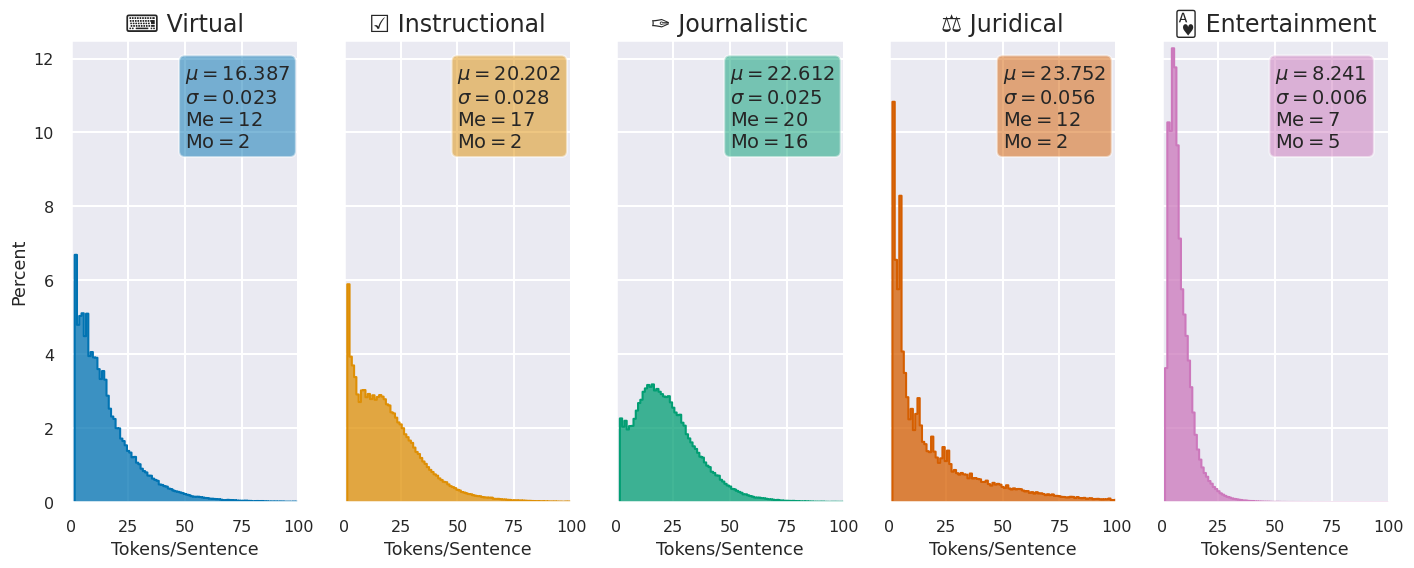

In [9]:
plot_sample_independent("sent_len", [0,100], [0,12.5],"Tokens/Sentence", ignore=[1,1,1,1,1])

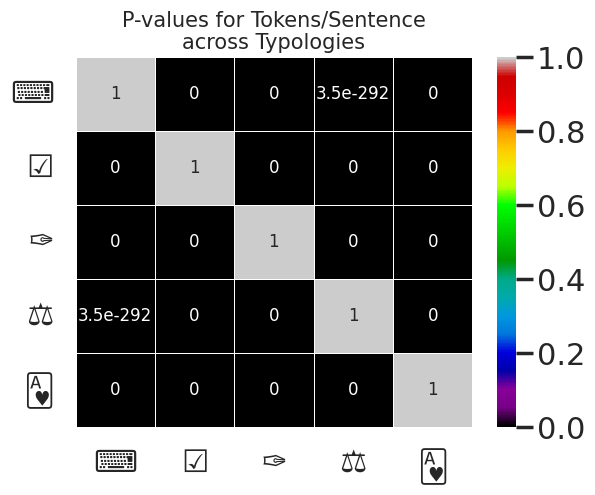

In [10]:
independent_compatibility_map("sent_len", "P-values for Tokens/Sentence\nacross Typologies", annot=True)

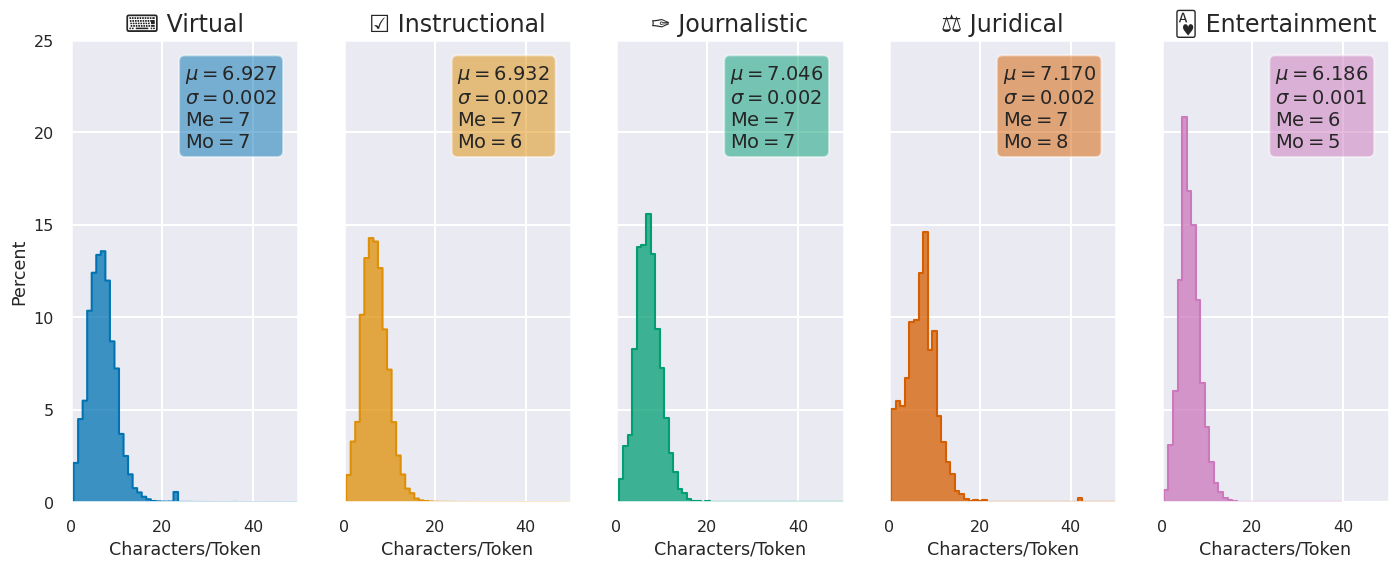

In [187]:
plot_sample_independent("token_len", [0,50], [0,25],"Characters/Token")

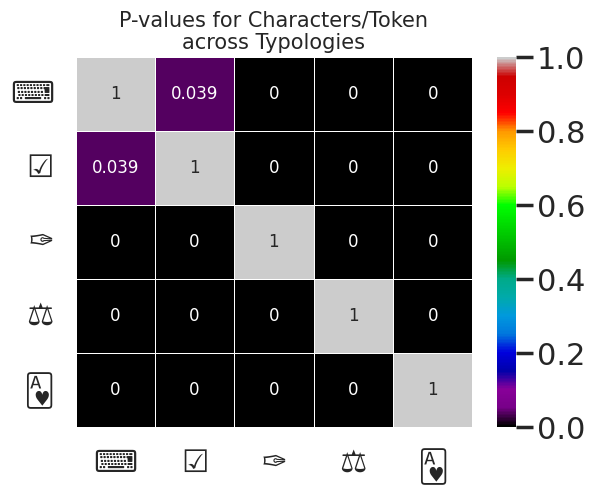

In [12]:
independent_compatibility_map("token_len", "P-values for Characters/Token\nacross Typologies", annot=True)

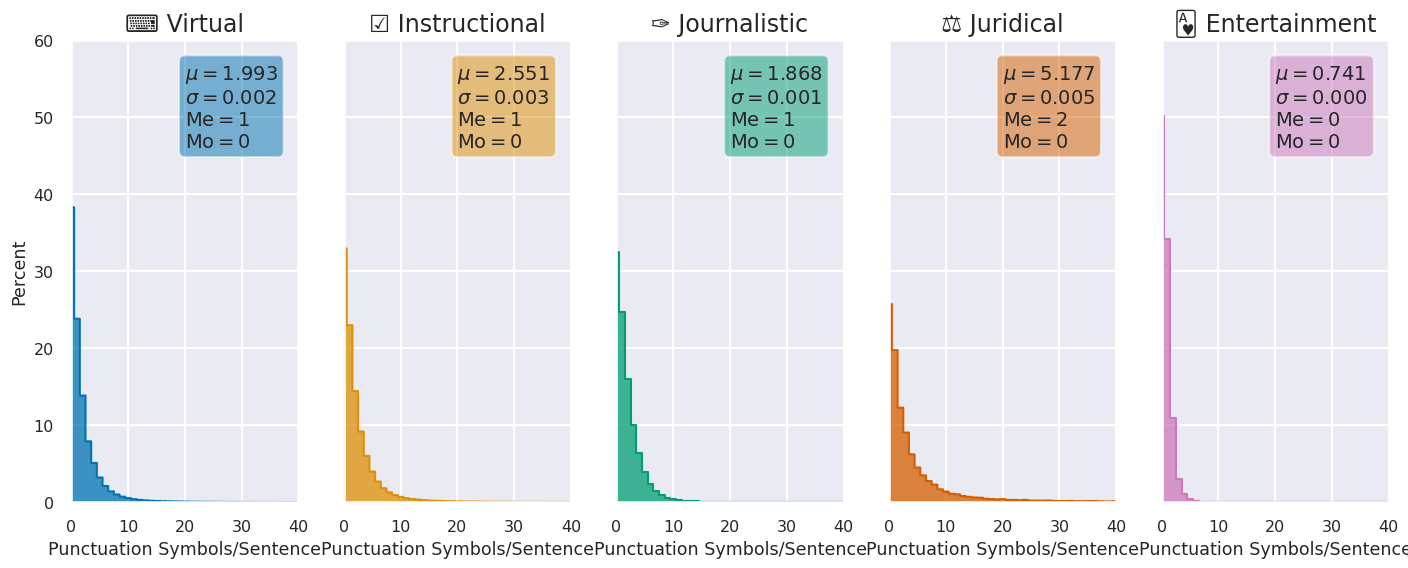

In [188]:
plot_sample_independent("punct_count", [0,40], [0,60],"Punctuation Symbols/Sentence")

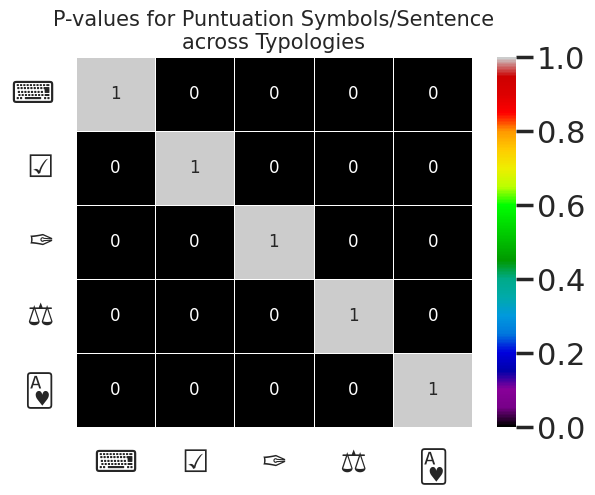

In [14]:
independent_compatibility_map("punct_count", "P-values for Puntuation Symbols/Sentence\nacross Typologies", annot=True)

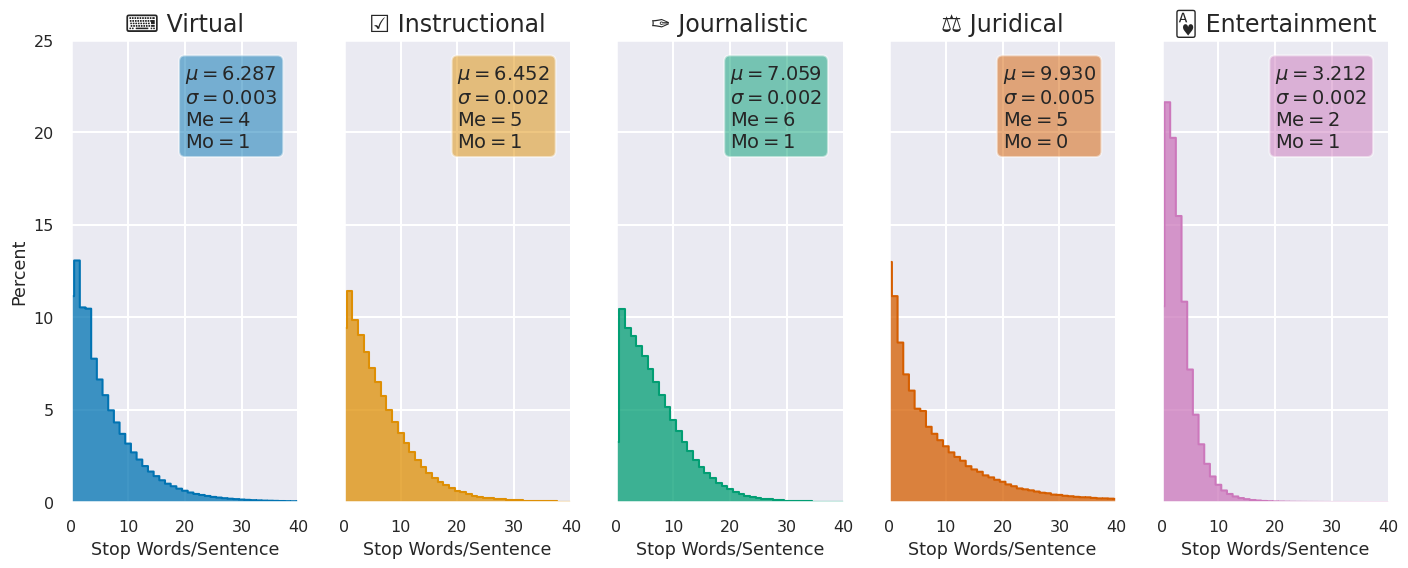

In [189]:
plot_sample_independent("stop_count", [0,40], [0,25],"Stop Words/Sentence")

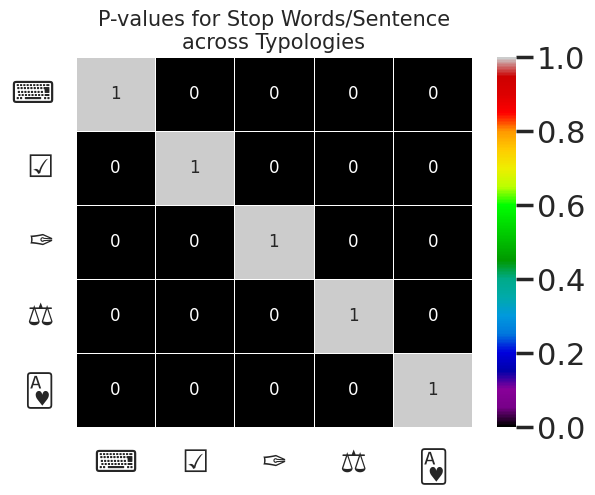

In [16]:
independent_compatibility_map("stop_count", "P-values for Stop Words/Sentence\nacross Typologies", annot=True)

In [91]:
def plot_sample_dependent(feature, title, xlabel, ylabel="Frequency",emojis=EMOJIS, style="darkgrid", context="poster", font_scale=0.8, ignore=[], xrotation=0):
    sns.set(style=style)
    sns.set_context(context, font_scale=font_scale)
    
    domains_w_emoji = [emojis[i] + " " + domains[i] for i in range(len(domains))]
    data = []
    sorted_keys = []
    for sample in range(SAMPLE_NUMBER):
        for domain, domain_w_emoji in zip(domains,domains_w_emoji):
            category_counts = Counter(sample_dependent_features[sample][domain][feature])
            if len(ignore) > 0:
                for i in ignore:
                    del category_counts[i]
            total = sum(category_counts.values(), 0.0)
            for key in category_counts:
                category_counts[key] /= total
            data += [[feature_value,category_counts[feature_value],domain_w_emoji] for feature_value in category_counts.keys()]
    # sorted_keys.append(sorted(category_counts, key=lambda x: category_counts[x], reverse=True))

    data = pd.DataFrame(data)
    data.columns =[feature, 'count', 'domain']


    sns.catplot(data=data, kind="bar", x=feature, y="count", hue="domain", palette="colorblind", alpha=.6, height=6, aspect=17/6, legend_out= False)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xrotation)

    plt.savefig("plots/" + feature + ".pdf")
    plt.savefig("plots/" + feature + ".png")

    return data
    



In [180]:
def dependent_compatibility_map(data, feature, title, xlabel, equal_var=False, emojis=EMOJIS, context="poster", font_scale=1, annot=False, figsize=(17,6)):
    sns.set_context(context, font_scale=font_scale)
    sns.set(rc={'figure.figsize':figsize})
    p_values = {}
    
    warnings.filterwarnings('ignore')

    for feature_value in data[feature].unique():
        p_values[feature_value] = {}
        for domain_a in data["domain"].unique():
            for domain_b in data["domain"].unique():
                if domain_a != domain_b:
                    a=data[data[feature]==feature_value][data["domain"]==domain_a]["count"].to_list()
                    b=data[data[feature]==feature_value][data["domain"]==domain_b]["count"].to_list()
                    if not domain_b[0]+"/"+domain_a[0] in p_values[feature_value].keys():
                        p_values[feature_value][domain_a[0]+"/"+domain_b[0]] = t_test(a,b,equal_var=equal_var)[1]
    
    p_df = pd.DataFrame(p_values)
    sns.heatmap(p_df, linewidths=0.5, cmap=sns.color_palette("nipy_spectral", as_cmap=True), annot=annot, annot_kws={"size":12})
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel)
    plt.savefig("plots/" + feature + "_comp.pdf")
    plt.savefig("plots/" + feature + "_comp.png")


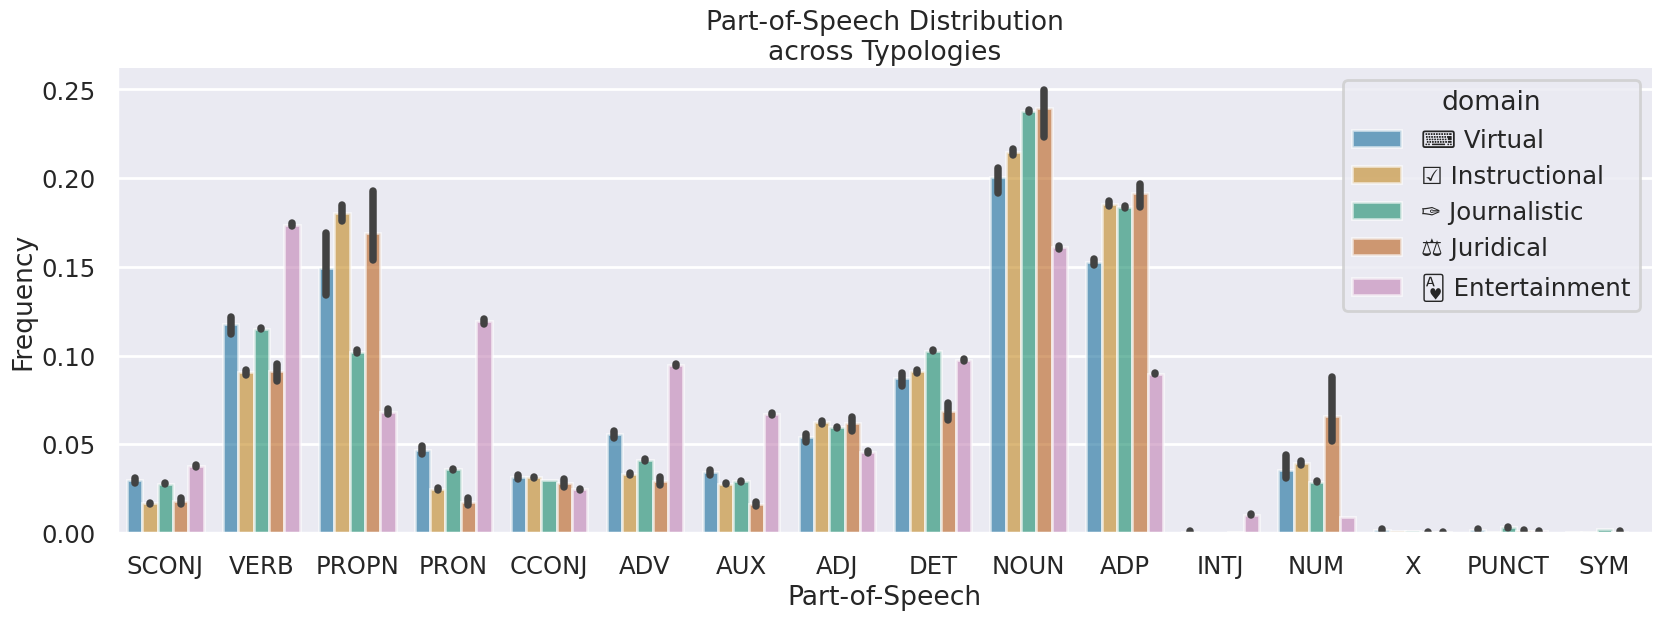

In [92]:
data_pos = plot_sample_dependent("pos", "Part-of-Speech Distribution\nacross Typologies", "Part-of-Speech", ignore=["PART"], xrotation=0, context="poster")

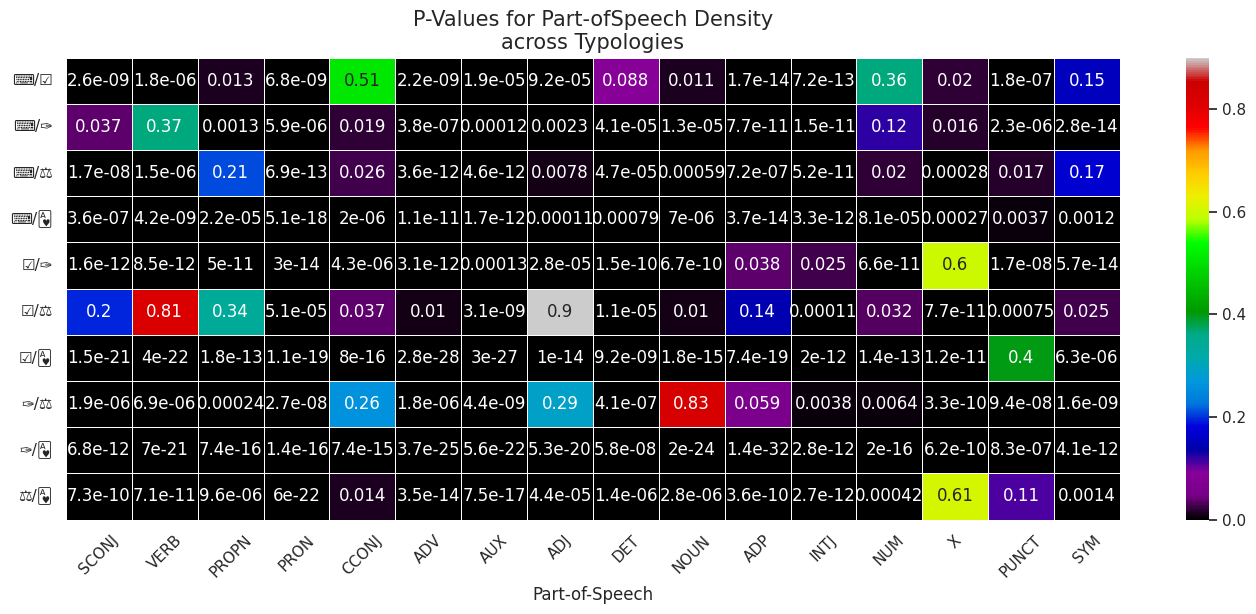

In [161]:
dependent_compatibility_map(data_pos, "pos", "P-Values for Part-ofSpeech Density\nacross Typologies", "Part-of-Speech", annot=True)

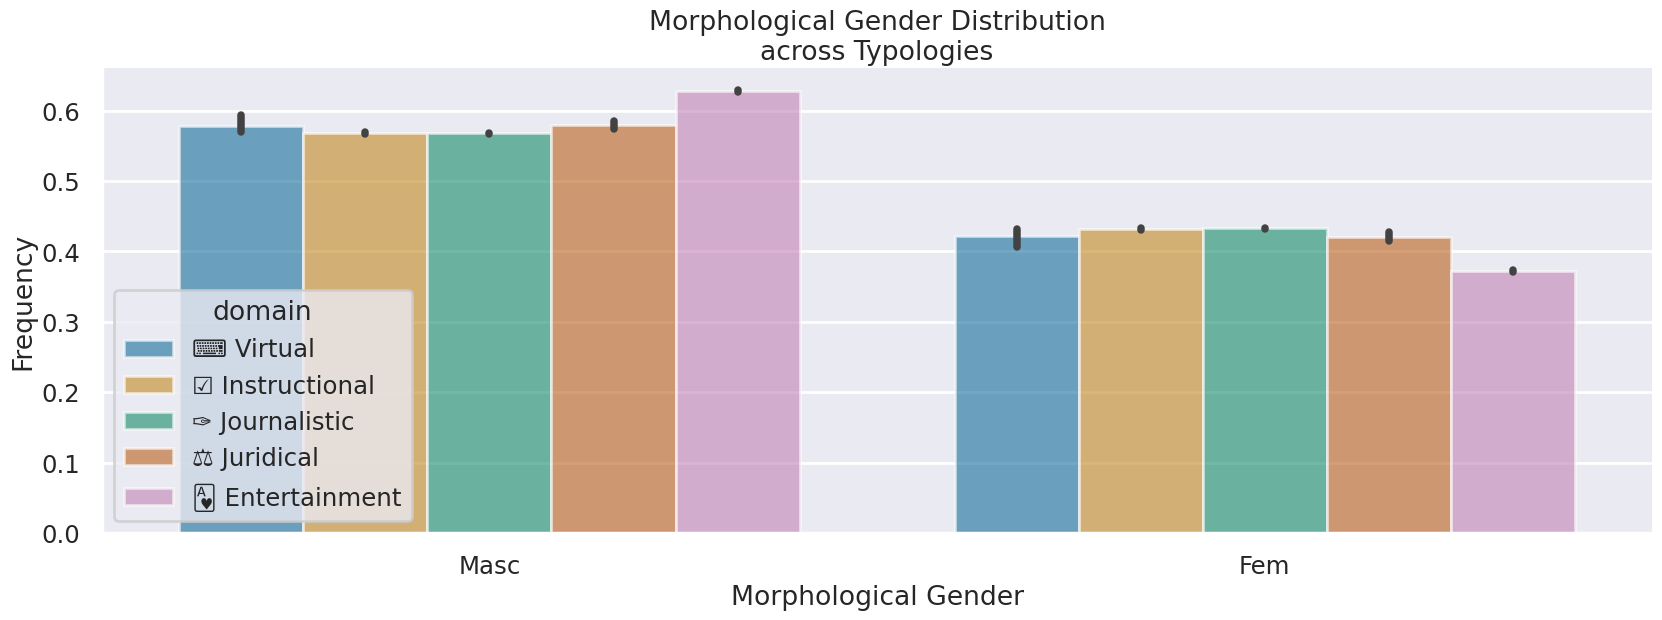

In [163]:
data_mg=plot_sample_dependent("morph_gender", "Morphological Gender Distribution\nacross Typologies", "Morphological Gender", xrotation=0, context="poster")

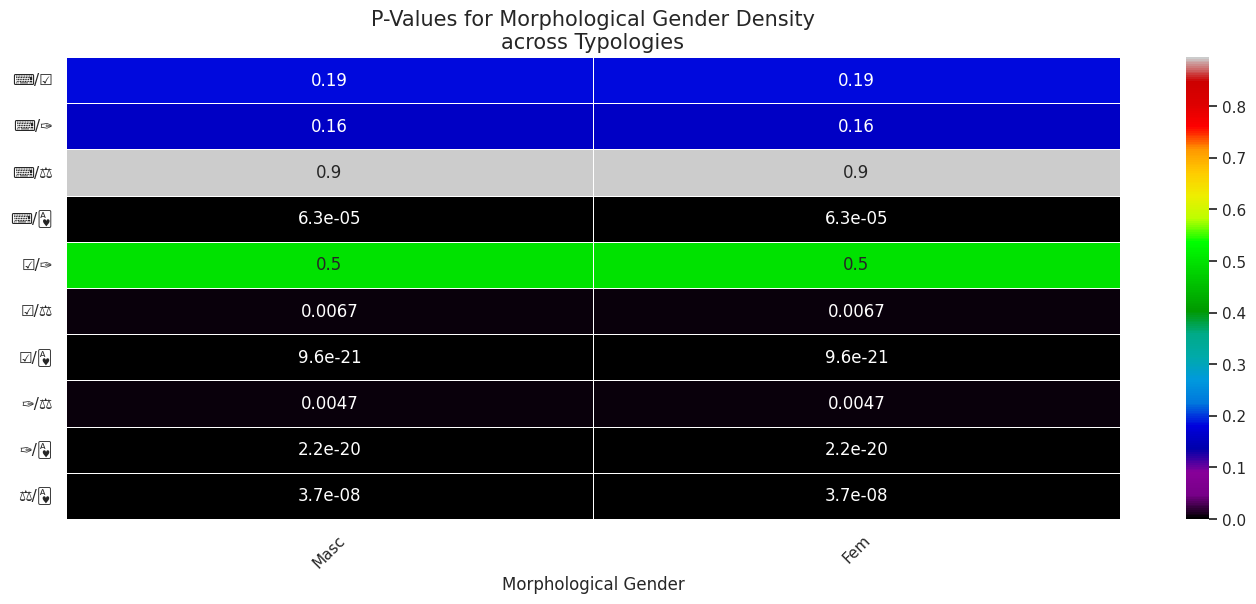

In [167]:
dependent_compatibility_map(data_mg, "morph_gender", "P-Values for Morphological Gender Density\nacross Typologies", "Morphological Gender", annot=True)

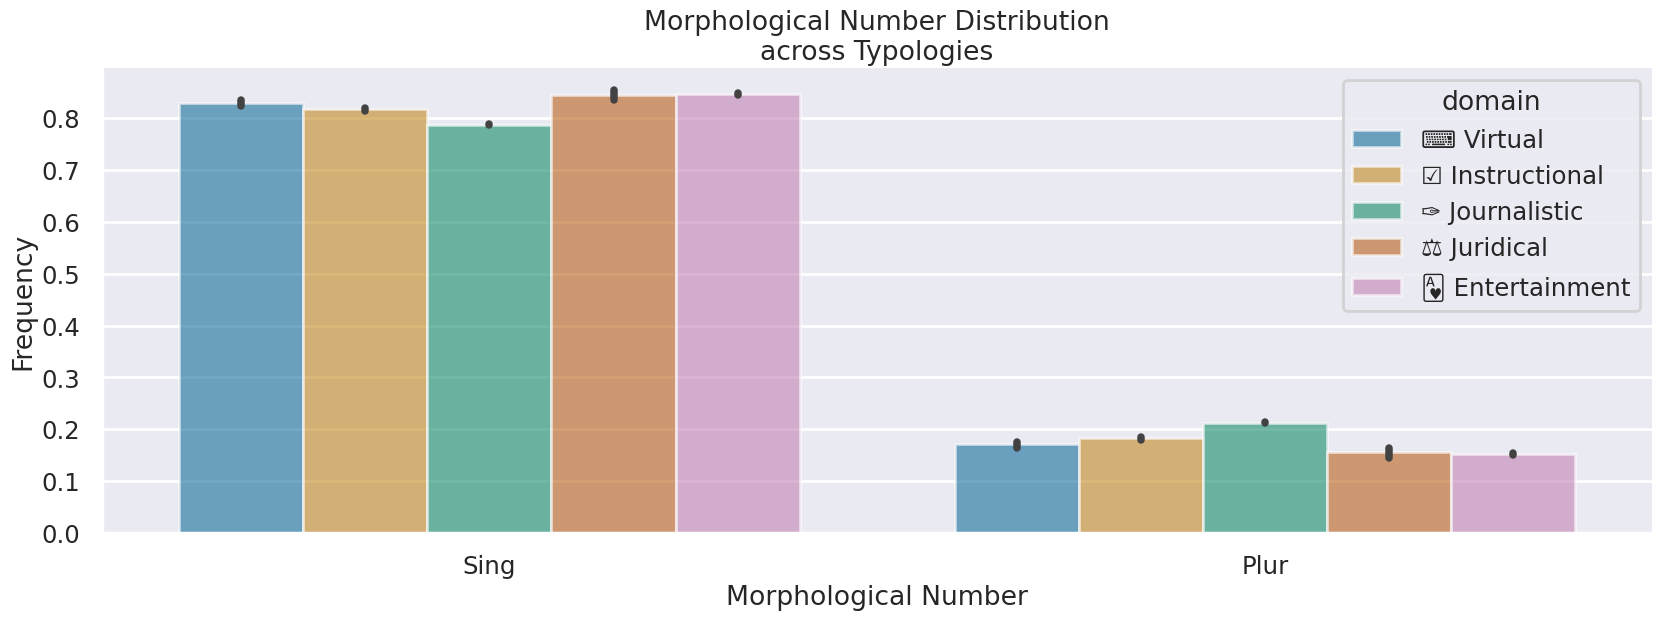

In [169]:
data_mn = plot_sample_dependent("morph_number", "Morphological Number Distribution\nacross Typologies", "Morphological Number", xrotation=0, context="poster")

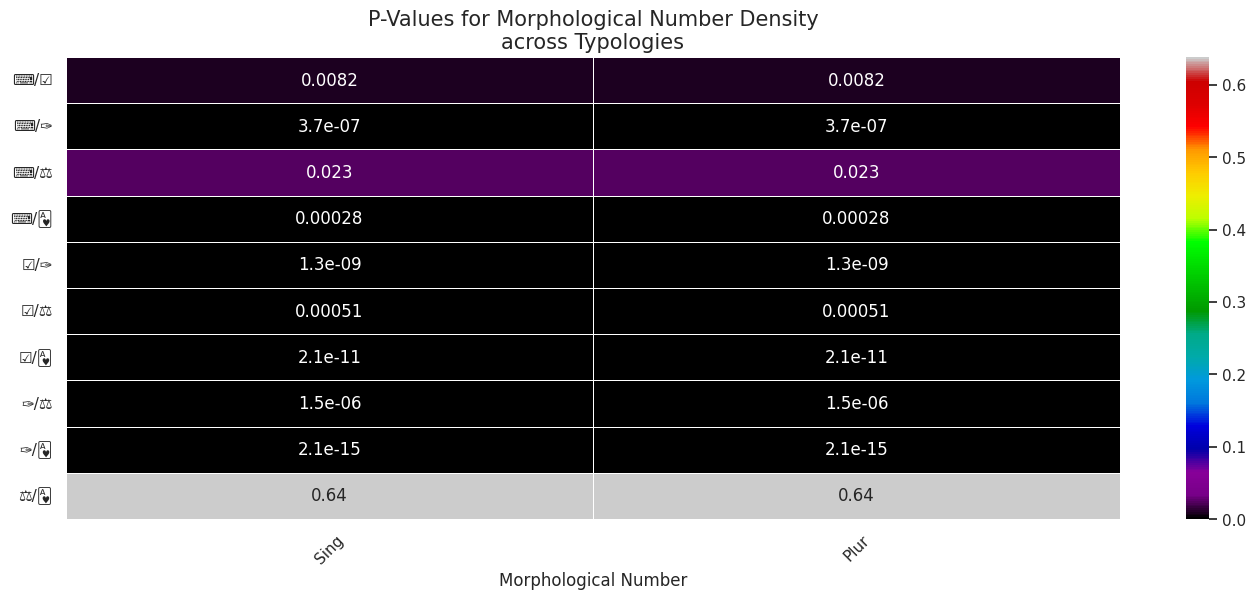

In [170]:
dependent_compatibility_map(data_mn, "morph_number", "P-Values for Morphological Number Density\nacross Typologies", "Morphological Number", annot=True)

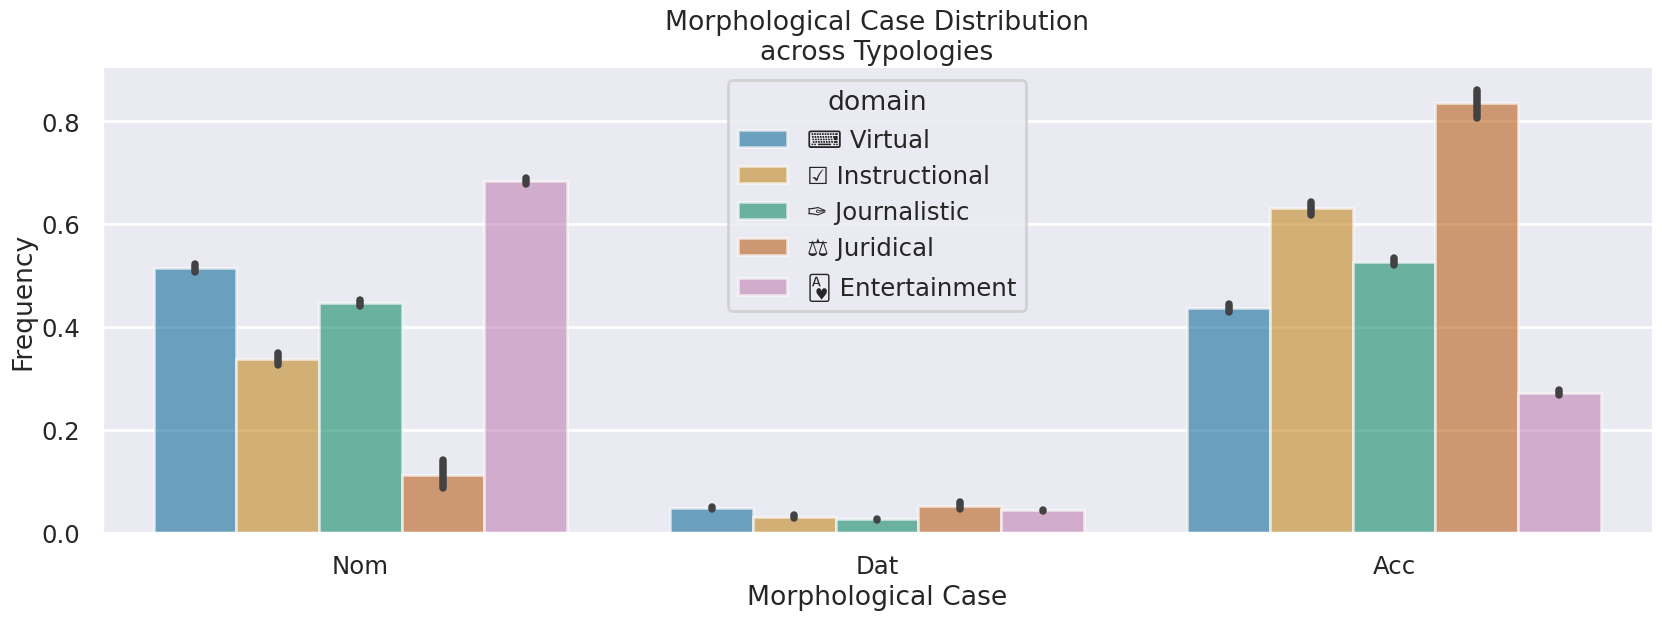

In [171]:
data_mc = plot_sample_dependent("morph_case", "Morphological Case Distribution\nacross Typologies", "Morphological Case", xrotation=0, context="poster")

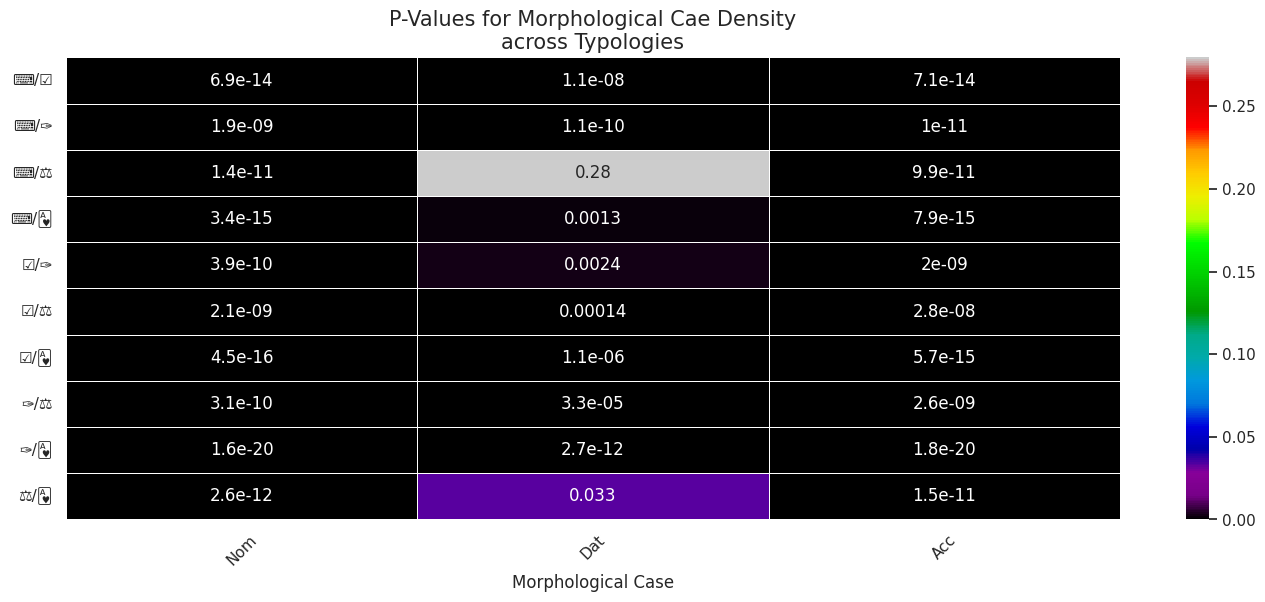

In [172]:
dependent_compatibility_map(data_mc, "morph_case", "P-Values for Morphological Cae Density\nacross Typologies", "Morphological Case", annot=True)

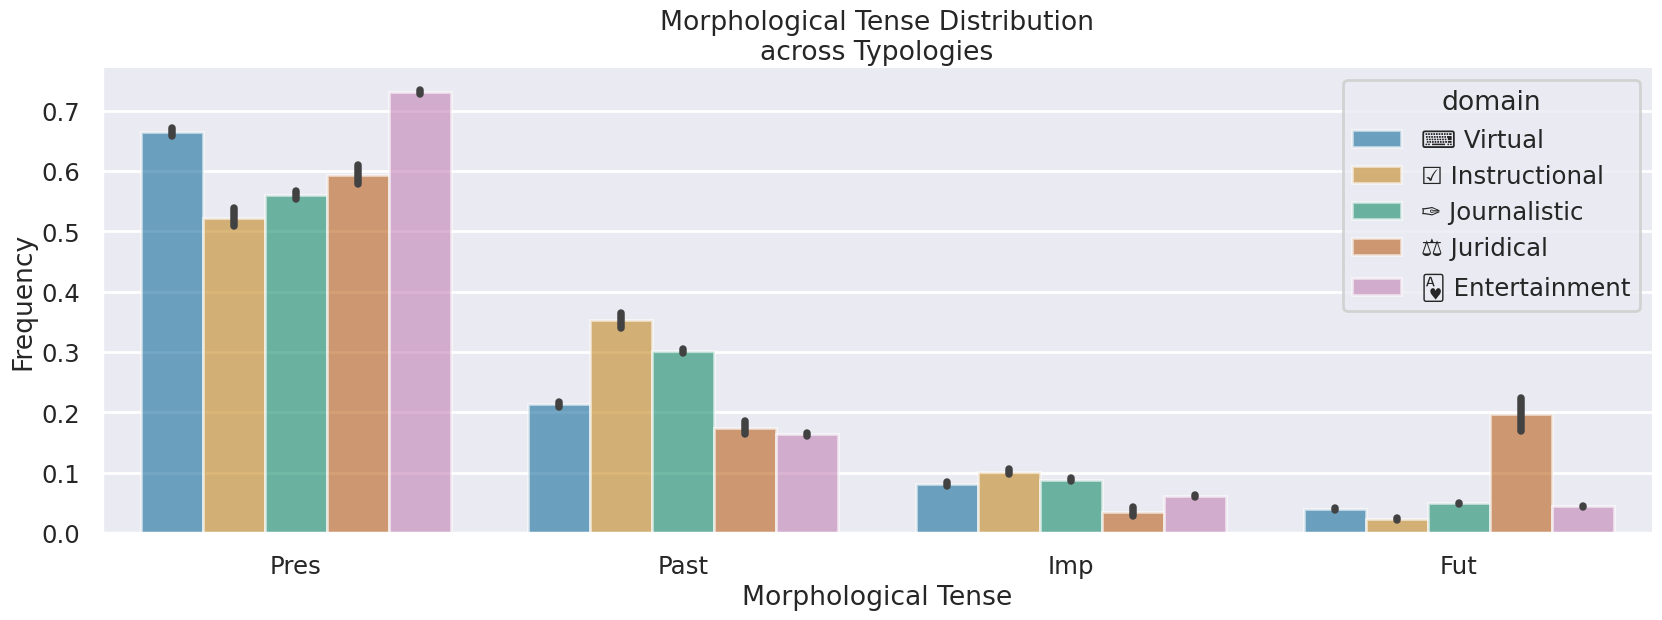

In [173]:
data_mt = plot_sample_dependent("morph_tense", "Morphological Tense Distribution\nacross Typologies", "Morphological Tense", xrotation=0, ignore=["Pqp"], context="poster")

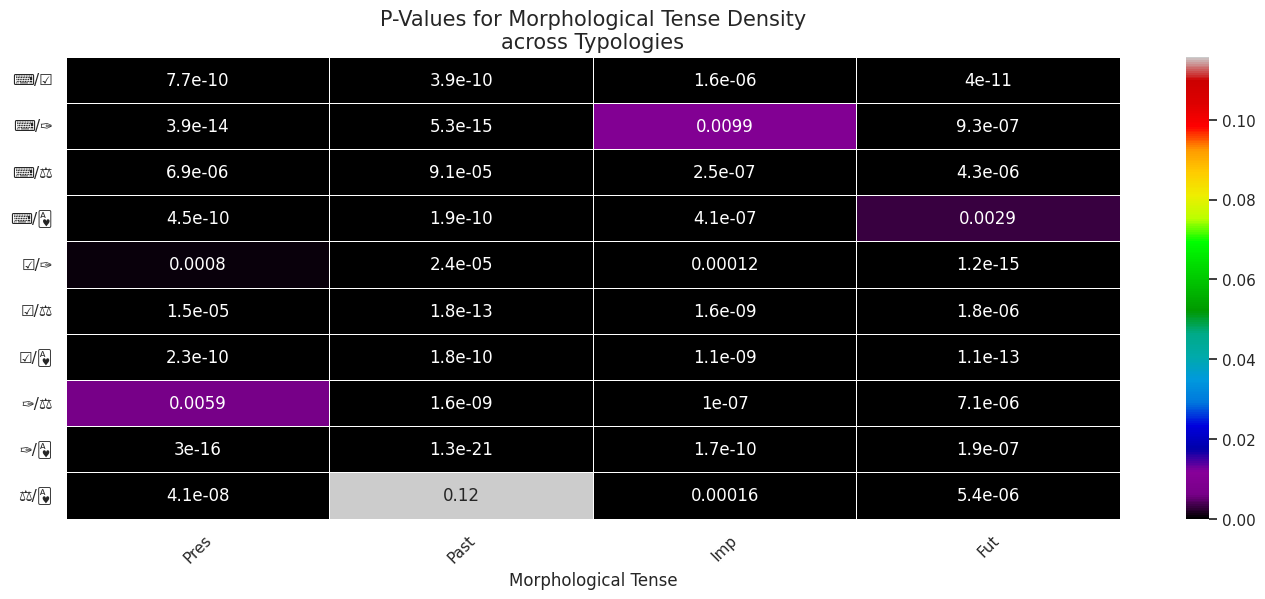

In [174]:
dependent_compatibility_map(data_mt, "morph_tense", "P-Values for Morphological Tense Density\nacross Typologies", "Morphological Tense", annot=True)

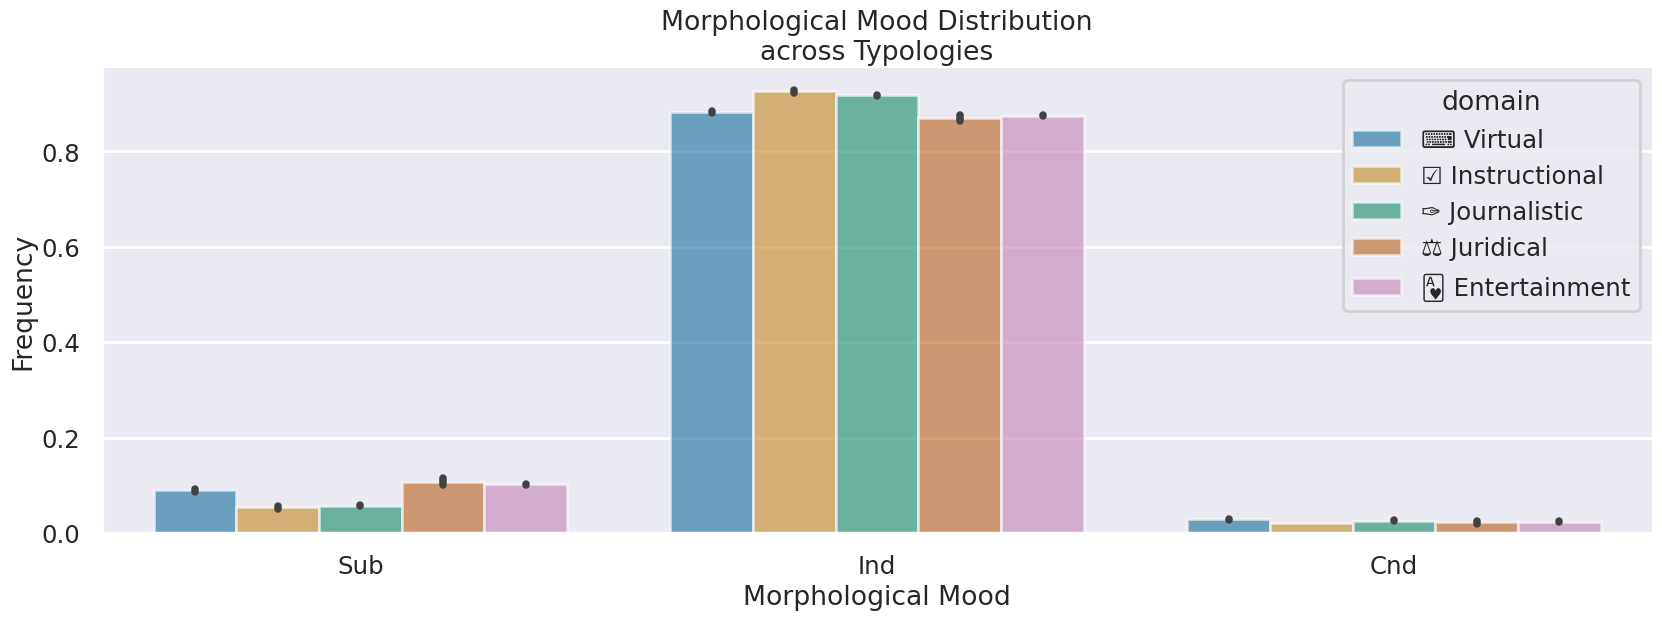

In [175]:
data_mm = plot_sample_dependent("morph_mood", "Morphological Mood Distribution\nacross Typologies", "Morphological Mood", ignore=["Imp"], xrotation=0, context="poster")

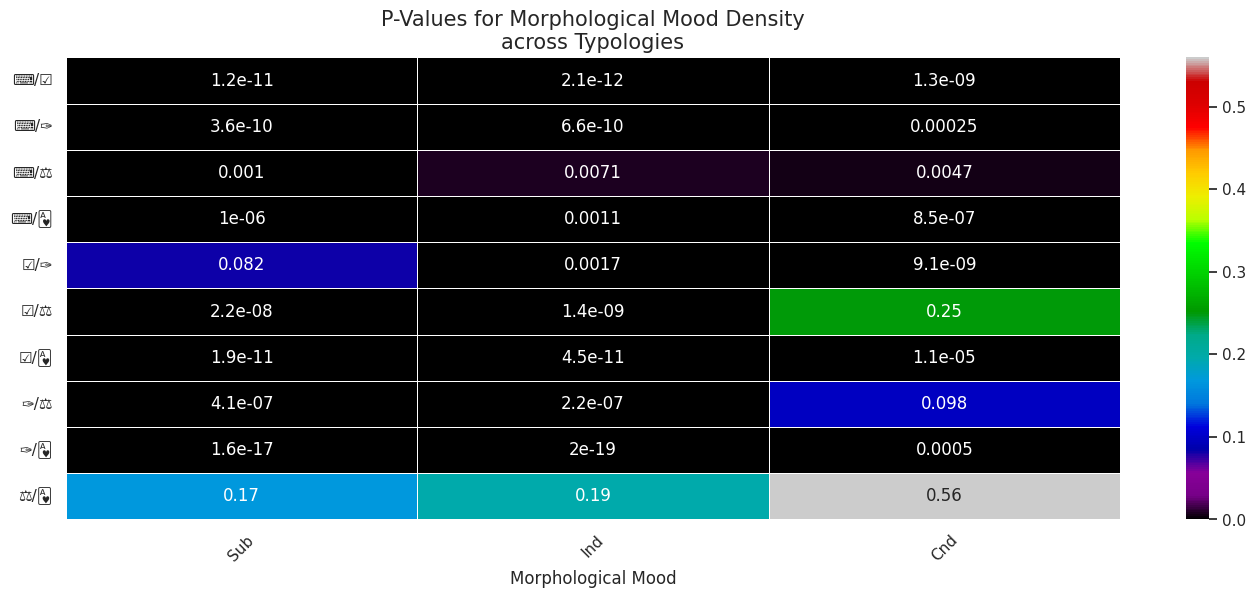

In [177]:
dependent_compatibility_map(data_mm, "morph_mood", "P-Values for Morphological Mood Density\nacross Typologies", "Morphological Mood", annot=True)

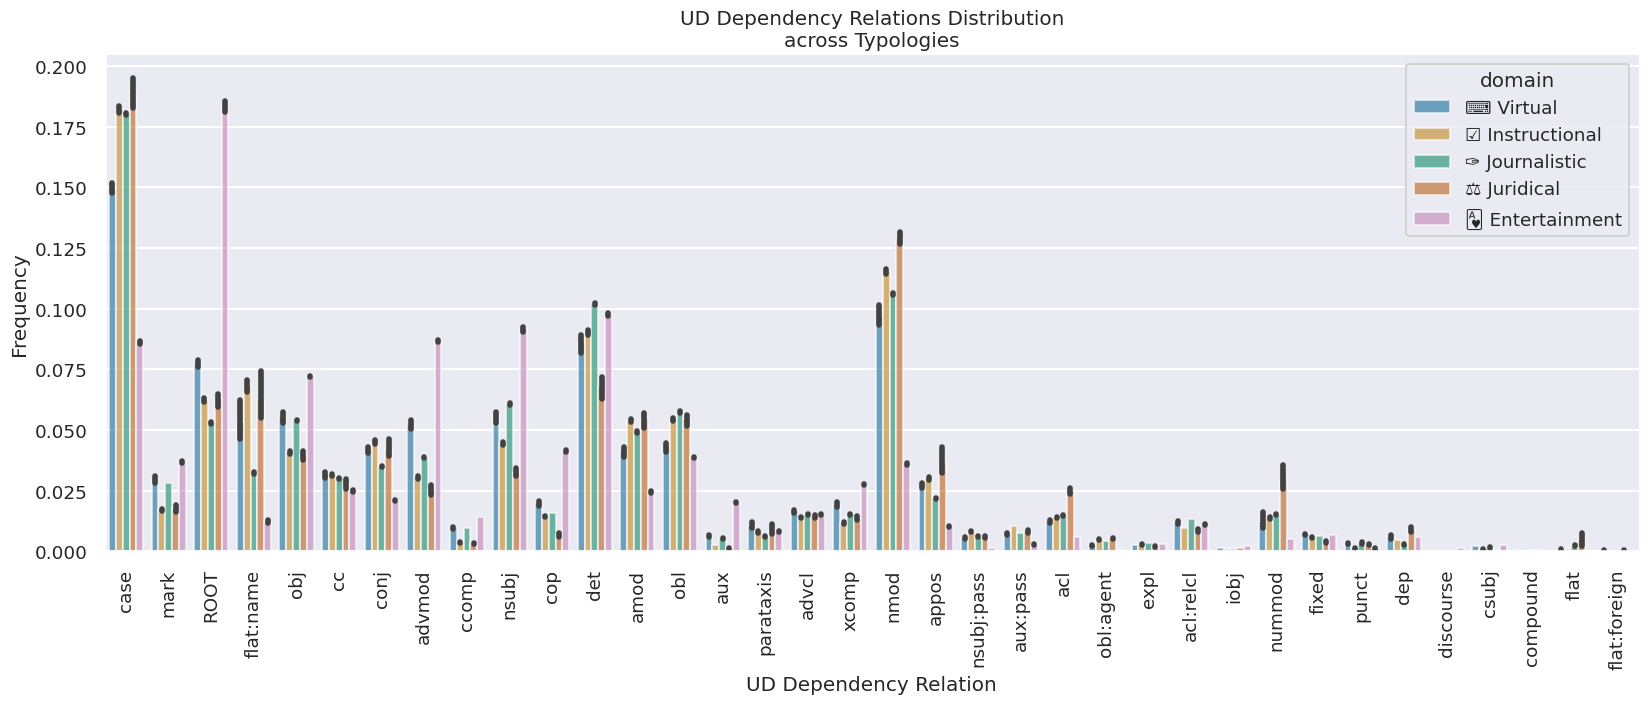

In [178]:
data_dep = plot_sample_dependent("dep", "UD Dependency Relations Distribution\nacross Typologies", "UD Dependency Relation", xrotation=90, context="talk")

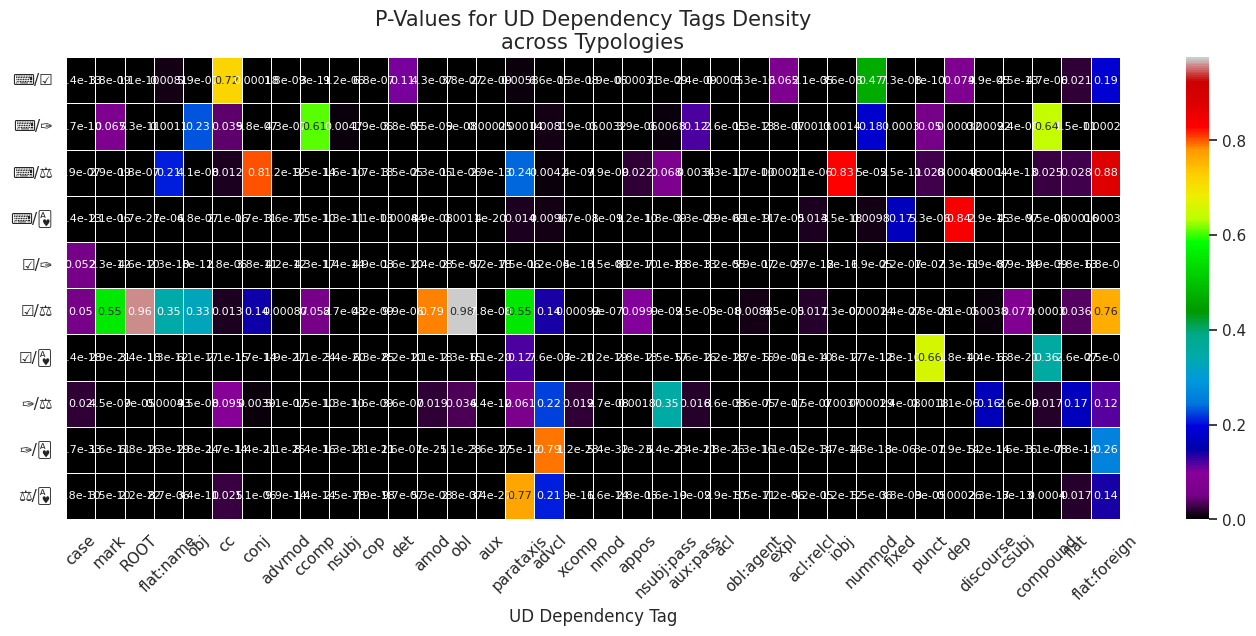

In [182]:
dependent_compatibility_map(data_dep, "dep", "P-Values for UD Dependency Tags Density\nacross Typologies", "UD Dependency Tag", annot=True)

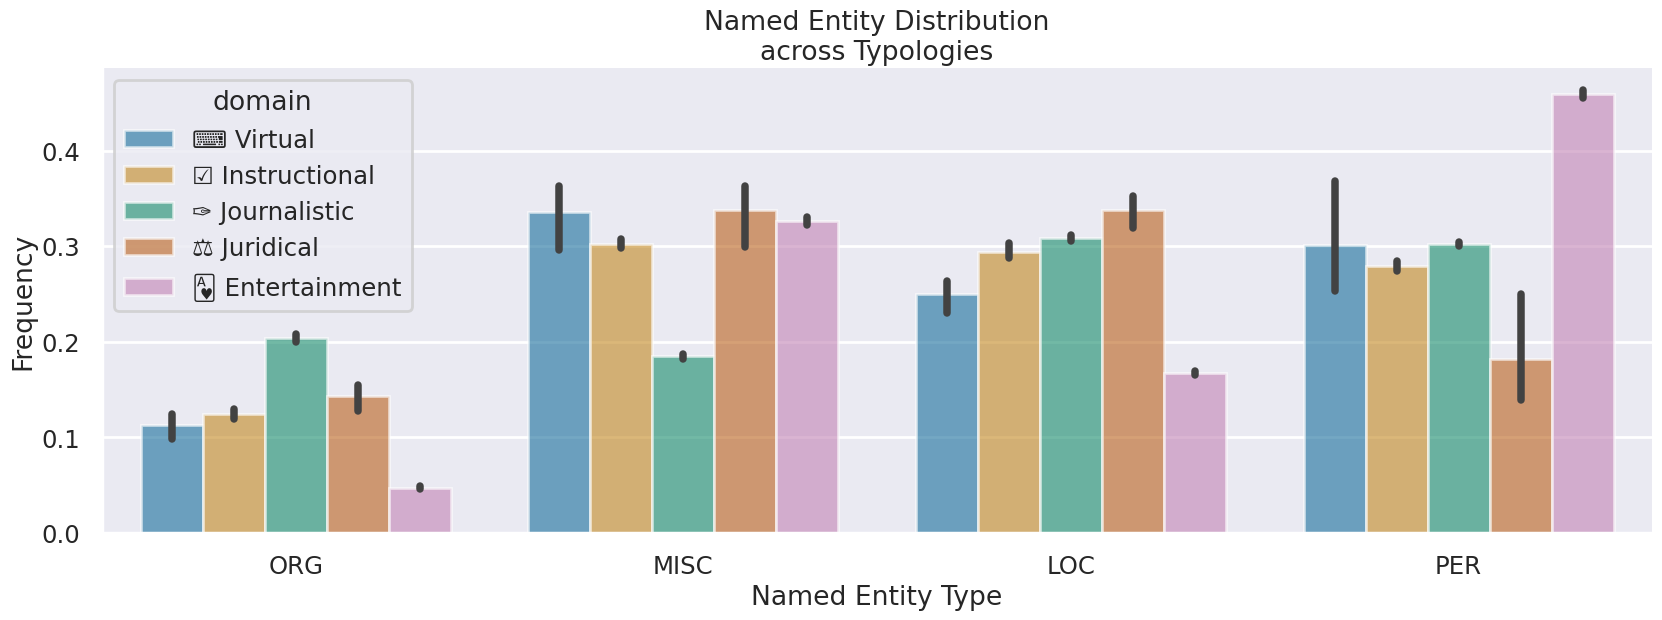

In [183]:
data_et = plot_sample_dependent("ent_type", "Named Entity Distribution\nacross Typologies", "Named Entity Type", xrotation=0, ignore=[""], context="poster")

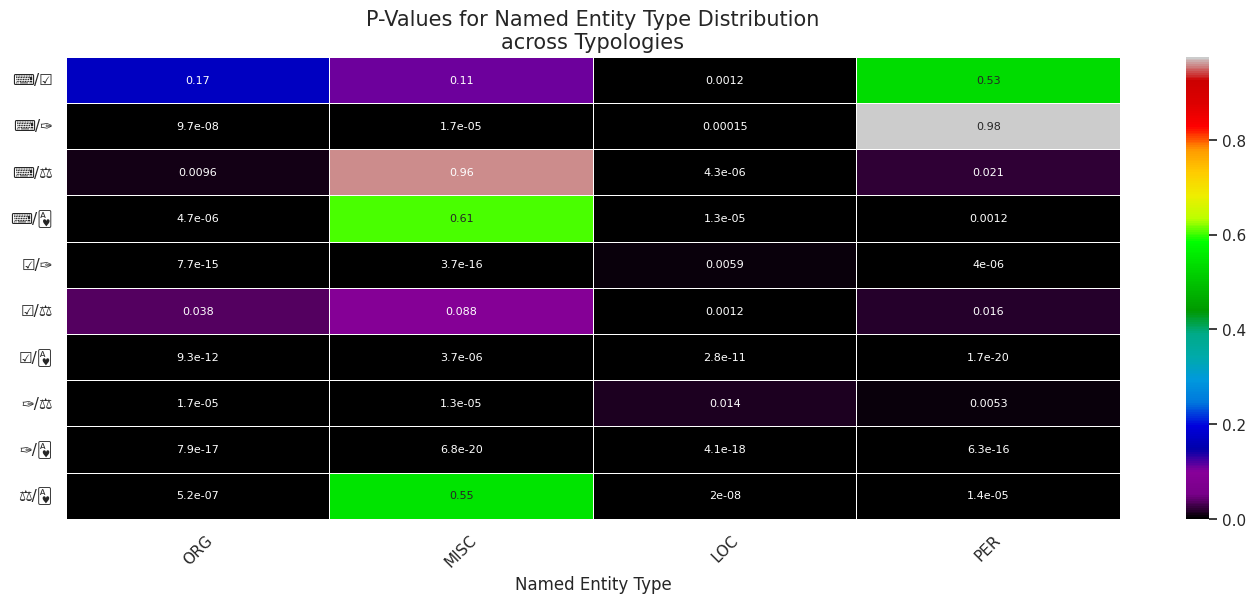

In [185]:
dependent_compatibility_map(data_et, "ent_type", "P-Values for Named Entity Type Distribution\nacross Typologies", "Named Entity Type", annot=True)